In [2]:
#packages required
from cmapPy.pandasGEXpress.parse_gct import parse
from cmapPy.pandasGEXpress.write_gct import write
import GSVA
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.decomposition import PCA as sklearnPCA

In [3]:
#parse PAAD.gct
master = parse('PAAD.gct')
#This GCT file contains 3 parts:
master.row_metadata_df.info()
#This gives an empty DataFrame with 18465 entries corresponding to genes SLC35E2 to psiTPTE22
master.col_metadata_df.info()
# This gives a dataFrame with: Index: 183 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
#Columns: 124 entries, participant_id to year_of_tobacco_smoking_onset
master.data_df.info()
#This gives the gene expression matrix

<class 'pandas.core.frame.DataFrame'>
Index: 18465 entries, SLC35E2 to psiTPTE22
Empty DataFrame<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
Columns: 124 entries, participant_id to year_of_tobacco_smoking_onset
dtypes: float64(49), int64(10), object(65)
memory usage: 131.5+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 18465 entries, SLC35E2 to psiTPTE22
Columns: 183 entries, aab1-Primary solid Tumor to aapl-Primary solid Tumor
dtypes: float32(183)
memory usage: 13.3+ MB


In [4]:
#Filtering out NaN values and genes which have same values across samples
#NaN
NaNcount = master.data_df.shape[0] - master.data_df.dropna(inplace = False).shape[0]
master.data_df.dropna(inplace = True)
master.row_metadata_df = master.row_metadata_df.loc[master.data_df.index]
master.row_metadata_df.info()
NaNcount
#Output is 4367 genes which have 1 or more NaN values

#genes which have same values across all samples or have zero value across samples
#duplicated genes
dup = master.data_df.duplicated()
dup.value_counts()


<class 'pandas.core.frame.DataFrame'>
Index: 14098 entries, SLC35E2 to ZZZ3
Empty DataFrame

False    14098
dtype: int64

In [10]:
#gene expression distribution: the questions we are trying to answer are:
#A. which samples are similar to each other? B. are there batch effects?
#HEATMAP
write(master,'PAAD_Cleaned2.gct')
#visualized in Phantasus
#https://ctlab.itmo.ru/phantasus/?session=x06c15163e165ea

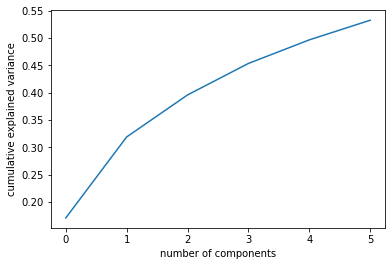

In [5]:
#BATCH EFFECTS
#These can be checked using PCA, which allows us to visualize multi-dimensional data on two axes to see if batches cluster
# to perform PCA, we need to write a file in which missing gene values are removed
sklearn_pca_var = sklearnPCA(n_components=6)
X = master.data_df.T
Y2 = sklearn_pca_var.fit_transform(X)
plt.plot(np.cumsum(sklearn_pca_var.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()
#4 components explain over 50% of the variance, plotting on a 2D map will allow us to see whether groups are clustered by batch
Batch_ = pd.DataFrame(data = Y2, columns = ('P1','P2','P3','P4','P5','P6'), index = master.col_metadata_df.index)
Batch_['batch'] = master.col_metadata_df['mRNAseq_cluster']

3.0    0.241573
4.0    0.224719
1.0    0.219101
5.0    0.168539
2.0    0.146067
Name: batch, dtype: float64

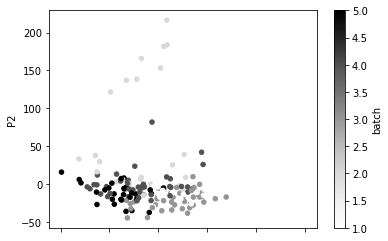

In [16]:
Batch_
Batch_.plot.scatter(x=0,y=1,c=6)
#We do see batch effects here in distribution of gene expression values across samples
#Is this because that batch contains a different histology, which can differentiate the sample?
Batch_['final_histology'] = master.col_metadata_df['final_histology'] #taken from below, run again
Batch_['batch'].value_counts(1) #number of samples is approximately equal from all batches


In [ ]:
#TOP 50 EXPRESSED GENES

#However, we cannot make conclusions about the genes since we do not have a control case of normal samples, if we had control cases,
#we can perform DGEA.

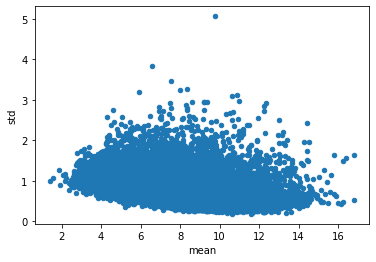

In [6]:
#pca
#PCA works better when std does not vary across mean values: we should check whether the normalization of the data allows
#effective PCA analysis
norm = pd.DataFrame()
norm['mean'] = master.data_df.mean(axis = 1)
norm['std'] = master.data_df.std(axis = 1)
norm.plot.scatter(x=0,y=1)
#we see here that std and mean are not linearly related so we can perform PCA analysis on the dataset without 
#the concern that low count genes or high count genes will overly contribute to the variance analysis: PCA

In [11]:
#Clean up values in histological_type_other to make a new col
#the general behavior of different samples:
# Upon inspection, I see that column 'histological_type' and 'histological_type_other' are complements. 'other' is used when 
# histological_type is not pancreas-adenocarcinoma ductal type. 
# They are put into a single column and values are cleaned

master.col_metadata_df['final_histology'] = master.col_metadata_df['histological_type_other']
master.col_metadata_df['final_histology'].fillna(value = 'pancreas-adenocarcinoma ductal type',inplace = True)
keys3 = master.col_metadata_df['final_histology'].unique()
vals = ['pancreas-adenocarcinoma', 'invasive, well-differentiated',
       'pancreas-adenocarcinoma',
       'poorly differentiated adenocarcinoma', 'neuroendocrine carcinoma', 'neuroendocrine carcinoma',
        'neuroendocrine carcinoma','neuroendocrine carcinoma','pancreas-adenocarcinoma',
       'poorly differentiated adenocarcinoma', 'not specified', 'intraductal tubulopapillary neoplasm',
        'ductal and micropapillary', 'pancreas-adenocarcinoma',
       'moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%','neuroendocrine carcinoma']
#Naming changed based on Wiki and https://www.archivesofpathology.org/doi/full/10.5858/arpa.2016-0405-RSR2.
#Here NOS is understood to be no other specification
res = {keys3[i]: vals[i] for i in range(15)} 
res
# master.col_metadata_df['final_histology'].isna().value_counts()

{'invasive adenocarcinoma': 'pancreas-adenocarcinoma',
 'invasive, well-differentiated': 'invasive, well-differentiated',
 'pancreas-adenocarcinoma ductal type': 'pancreas-adenocarcinoma',
 'poorly differentiated adenocarcinoma': 'poorly differentiated adenocarcinoma',
 'neuroendocrine': 'neuroendocrine carcinoma',
 'neuroendocrine carcinoma nos': 'neuroendocrine carcinoma',
 '82463 neuroendocrine carcinoma nos': 'neuroendocrine carcinoma',
 'neuroendocrine carcinoma': 'neuroendocrine carcinoma',
 'adenocarcinoma, nos': 'pancreas-adenocarcinoma',
 'poorly differentiated pancreatic adenocarcinoma': 'poorly differentiated adenocarcinoma',
 'not specified': 'not specified',
 'intraductal tubulopapillary neoplasm': 'intraductal tubulopapillary neoplasm',
 'ductal and micropapillary': 'ductal and micropapillary',
 'adenocarcinoma- nos': 'pancreas-adenocarcinoma',
 'moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%': 'moderately differentiated ductal adenocarcinoma 60%

In [12]:
master.col_metadata_df['final_histology'].replace(res, inplace = True)
master.col_metadata_df['final_histology']
# master.col_metadata_df['histological_type_other'].head()

cid
aab1-Primary solid Tumor          pancreas-adenocarcinoma
aab4-Primary solid Tumor    invasive, well-differentiated
aab6-Primary solid Tumor          pancreas-adenocarcinoma
aab8-Primary solid Tumor          pancreas-adenocarcinoma
aab9-Primary solid Tumor          pancreas-adenocarcinoma
                                        ...              
a89d-Solid Tissue Normal          pancreas-adenocarcinoma
a89d-Primary solid Tumor          pancreas-adenocarcinoma
a8sy-Primary solid Tumor          pancreas-adenocarcinoma
a8lh-Primary solid Tumor          pancreas-adenocarcinoma
aapl-Primary solid Tumor          pancreas-adenocarcinoma
Name: final_histology, Length: 183, dtype: object

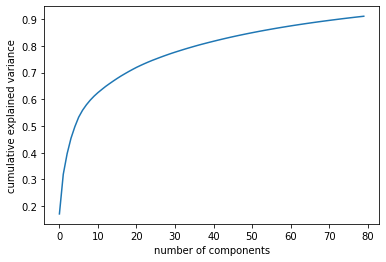

In [13]:
#PCA
X = master.data_df.T.values
y = master.col_metadata_df['final_histology']
#data does not need to be scaled
sklearn_pca = sklearnPCA(n_components=10)
Y = sklearn_pca.fit_transform(X)
#Verification
len(Y)
X
len(X)

#Variance of PCA


sklearn_pca_var = sklearnPCA(n_components=80)
Y2 = sklearn_pca_var.fit_transform(X)
plt.plot(np.cumsum(sklearn_pca_var.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');
plt.show()

#Plotting this curve allows us to see that 10 components represent around 60% of variance so information loss is large when we
#visualize 2 or 3 components, however, we can analyze multiple plots to see if trend of clusters exists across dimensions

In [14]:
#Conclusion of PCA:
PCA_plot = pd.DataFrame(data = Y, columns = (sklearn_pca.explained_variance_ratio_))

keys2 = master.col_metadata_df['final_histology'].unique()
vals2 = [10,9,8,7,6,5,4,3,2,1]
res2 = {keys2[j]: vals2[j] for j in range(8)} 
PCA_plot['final_histology'] = master.col_metadata_df['final_histology'].values
PCA_plot['NewKey'] = PCA_plot['final_histology'].replace(res2)
res2 #use as legend

#used loc when error came about because 

{'pancreas-adenocarcinoma': 10,
 'invasive, well-differentiated': 9,
 'poorly differentiated adenocarcinoma': 8,
 'neuroendocrine carcinoma': 7,
 'not specified': 6,
 'intraductal tubulopapillary neoplasm': 5,
 'ductal and micropapillary': 4,
 'moderately differentiated ductal adenocarcinoma 60% + neuroendocrine 40%': 3}

c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:298: MatplotlibDeprecationWarning: 
The colNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().colspan.start instead.
  layout[ax.rowNum, ax.colNum] = ax.get_visible()
c:\users\hp\appdata\local\programs\python\python38-32\lib\site-packages\pandas\plotting\_matplotlib\tools.py:304: MatplotlibDeprecationWarning: 
The rowNum attribute was deprecated in Matplotlib 3.2 and will be removed two minor releases later. Use ax.get_subplotspec().rowspan.start instead.
  if not layout[ax.ro

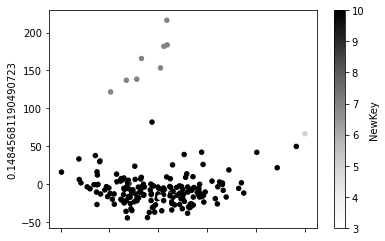

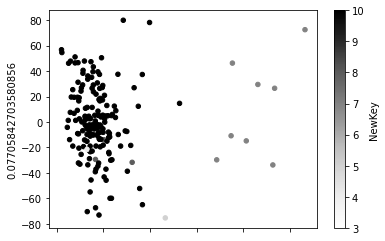

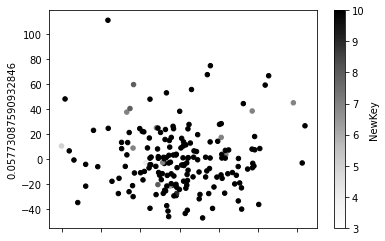

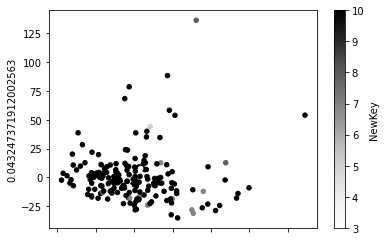

In [15]:
#PCA
PCA_plot.plot.scatter(x=0,y=1,c=11)
PCA_plot.plot.scatter(x=1,y=2,c=11)
PCA_plot.plot.scatter(x=2,y=3,c=11)
PCA_plot.plot.scatter(x=3,y=4,c=11)

#Neuroendocrine tumors separate out when plotted in 3 dimensions, which explains 30% of information.
#Gene set data is very noisy, so PCA is an effective tool to filter out noise and cluster 
    #Source: Detecting Stable Clusters UsingPrincipal Component Analysis Asa Ben-Hur and Isabelle Guyon
#However, since the PCA is so lossy, it needs further investigation, which can be done using Euclidean distance matrices.

In [26]:
#Removing neuroendocrine tumors from GCT file
adeno_only_col = master.col_metadata_df
adeno_only_data = master.data_df
a = ['neuroendocrine carcinoma']

adeno_only_col = adeno_only_col[~adeno_only_col.final_histology.isin(a)]
adeno_only_data = adeno_only_data.loc[:,adeno_only_col.index]

#Now we have two dataframes, one with metadata, second with data, with 175 patient samples

In [17]:
adeno_only_data.index

Index(['SLC35E2', 'A1BG', 'A2LD1', 'A2M', 'A4GALT', 'AAAS', 'AACS', 'AADAT',
       'AAGAB', 'AAK1',
       ...
       'ZW10', 'ZWILCH', 'ZWINT', 'ZXDA', 'ZXDB', 'ZXDC', 'ZYG11B', 'ZYX',
       'ZZEF1', 'ZZZ3'],
      dtype='object', name='rid', length=14098)

chd,participant_id,sample_type,mRNAseq_cluster,bcr_patient_barcode,bcr_patient_uuid,vital_status,days_to_death,days_to_last_followup,additional_studies,adenocarcinoma_invasion,...,total_dose,total_dose_units,tumor_tissue_site,tumor_type,withdrawn,year_of_dcc_upload,year_of_form_completion,year_of_initial_pathologic_diagnosis,year_of_tobacco_smoking_onset,final_histology
cid,,,,,,,,,,,,,,,,,,,,,
aab1-Primary solid Tumor,aab1,Primary solid Tumor,1.0,tcga-2j-aab1,75119d1a-93e5-4ae7-9d60-69ee929a0772,dead,66.0,NaN,NaN,yes,...,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,1962.0,pancreas-adenocarcinoma
aab4-Primary solid Tumor,aab4,Primary solid Tumor,2.0,tcga-2j-aab4,33833131-1482-42d5-9cf5-01cade540234,alive,NaN,729.0,NaN,yes,...,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN,"invasive, well-differentiated"
aab6-Primary solid Tumor,aab6,Primary solid Tumor,3.0,tcga-2j-aab6,70797499-16e6-48cc-8ae4-1e692713dad3,dead,293.0,NaN,NaN,yes,...,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN,pancreas-adenocarcinoma
aab8-Primary solid Tumor,aab8,Primary solid Tumor,1.0,tcga-2j-aab8,2e8f90f4-aed3-43b0-985c-dfdc2581f24f,alive,NaN,80.0,NaN,yes,...,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN,pancreas-adenocarcinoma
aab9-Primary solid Tumor,aab9,Primary solid Tumor,4.0,tcga-2j-aab9,a5748656-5330-417a-8938-01f69ddb3576,dead,627.0,NaN,NaN,yes,...,NaN,NaN,pancreas,primary,false,2016,2014,2012.0,NaN,pancreas-adenocarcinoma


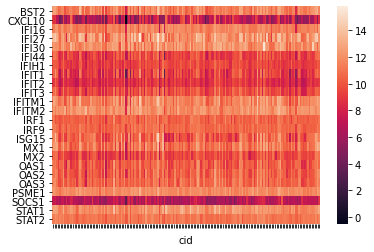

In [18]:
#Question 3:
#Understand the effect of Interferons in Pancreatic Adenocarcinoma
labels = pd.Index(["IFIT1","IFI44","IFIT3","MX2","OAS1","OAS3","BST2","IFITM1","MX1",
                  "STAT1","IFI27","CXCL10","IFI16","IFI30","IFIH1","IFIT2", 
                  "IFITM2","IRF1","IRF9","IRGM","ISG15","OAS2","PSME1","SOCS1",
                  "STAT2"])

#can this be read directly from file into a tuple to make it hashable?
IFN_ = adeno_only_data.loc[adeno_only_data.index.intersection(labels)]
#Gene expression values for these genes using HEATMAP
fig, ax = plt.subplots()
ax = sns.heatmap(IFN_,xticklabels=True, yticklabels=True)
ax.set(xticklabels=[])
plt.show
adeno_only_col.head()
# We see that the gene expression values are quite consistent from sample to sample, from the horizontal bands obtained

In [19]:
#GSVA scores of a signature tell us how positively or negatively genes in a geneset are enriched compared 
#to the rest of the genes in the data: difference of absolute values highest and lowest change
genesets_df = GSVA.gmt_to_dataframe('Book12.gmt')
temp = adeno_only_data.values
expression_df = pd.DataFrame(temp, columns = adeno_only_col.index, index = master.row_metadata_df.index)

# ans  = GSVA.gsva(expression_df, genesets_df, kcdf="Poisson", verbose = True)


In [20]:
#Limitation of GSVA
#Upon reading the original paper, we come across a limitation of GSVA i.e.
#since it takes the difference of the absolute values of the maximum positive and negative,
#it is not able to produce high scores: indicating highly enriched genes if both + and - values are present.
#The same ios validated in Gene set analysis approaches for RNA-seq data: performance evaluation and application guideline 
# by Yasir Rahmatallah, Frank Emmert-Streib, Galina Glazko

#Comparison of GSVA methods



In [53]:
#Export GSVA to csv
ans.to_csv('FinalOutput3.csv')
#Overlay col_metadata onto output
adeno_only_col['IFN Human Signature'] = ans.values
#After plotting data on a barplot, we see that samples seperate out into two subtypes: 
#one where GSVA score is positive (meaning highly over-expressed,
#and one where GSVA score is negative (meaning under-expressed,

ValueError: Length of values does not match length of index

In [ ]:
#Does GSVA aggregate samples into sub-types?4
#Statistical ranking for GSVA scores for by the top decile and bottom quartile may be defined as IFN high or low
#These cluster into sub-types: what are those?
#a. anatomic_neoplasm_subdivision?
#b. diabetes onset

In [ ]:
#Additional Analysis of Data
#A. Disease Codes: Tumor Site
# Comparison of icd_o_3_site and anatomic_neoplasm_subdivision shows some discrepencies in c25.1 which can be cleaned easily
#B. Some columns in metadata have no information and can be removed
#C. We can also check how many samples were not detected by mononucleotide_and_dinucleotide_marker_panel_analysis_status
#    which is a PCR based microsatellite test
#  https://bioconductor.org/packages/release/bioc/vignettes/TCGAbiolinks/inst/doc/clinical.html
